In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import kagglehub

import metric
import regularization as reg

from gradient_descent import gradient_descent, get_stop
from loss import LogLoss
from model import BinaryLogisticRegressionModel, LinearRegressionModel

In [2]:
DATASET_SIZE = 150
INV_TEST_FRAC = 5
MIN_CORRELATION = 0.2

In [3]:
path = kagglehub.dataset_download("uciml/iris")
dataset = pd.read_csv(path+"/Iris.csv").head(DATASET_SIZE)
dataset = dataset.drop(columns=["Id"])
feats = dataset.columns.to_list()
outcome = "Species"
feats.remove(outcome)
path

'/home/yrian/.cache/kagglehub/datasets/uciml/iris/versions/2'

In [4]:
dataset = dataset.dropna().sample(frac=1)
for feat in dataset:
    match dataset[feat][0]:
        case str():
            dataset[feat], d = pd.factorize(dataset[feat])
        case float() | int():
            dataset[feat] = (dataset[feat] - dataset[feat].min())/(dataset[feat].max() - dataset[feat].min())
dataset

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
66,0.361111,0.416667,0.593220,0.583333,0
52,0.722222,0.458333,0.661017,0.583333,0
61,0.444444,0.416667,0.542373,0.583333,0
24,0.138889,0.583333,0.152542,0.041667,1
112,0.694444,0.416667,0.762712,0.833333,2
...,...,...,...,...,...
1,0.166667,0.416667,0.067797,0.041667,1
2,0.111111,0.500000,0.050847,0.041667,1
16,0.305556,0.791667,0.050847,0.125000,1
38,0.027778,0.416667,0.050847,0.041667,1


<Axes: >

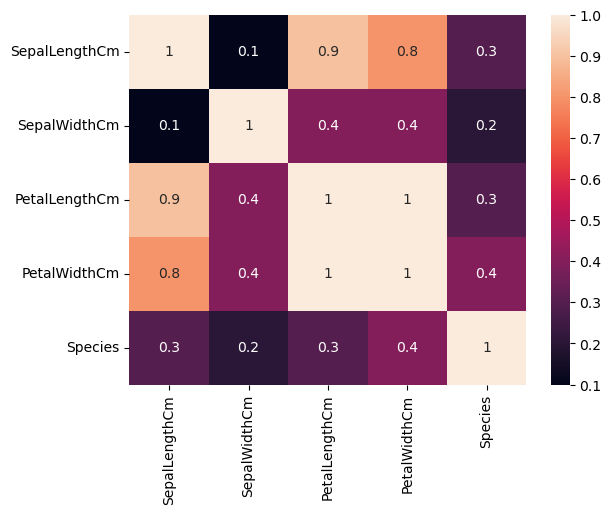

In [5]:
sns.heatmap(
    round(
        abs(dataset.corr()),
        1,
    ),
    annot=True,
)

In [6]:
# for feat in feats[:]:
#     if (abs(scipy.stats.pearsonr(x=dataset[feat], y=dataset[outcome]).statistic)) < MIN_CORRELATION:
#         feats.remove(feat)
feats = ["SepalWidthCm", "SepalLengthCm"]
dataset = dataset[feats + [outcome]]
dataset[outcome] = dataset[outcome] == d.to_list().index('Iris-setosa')
dataset["SepalLengthCm"] = 1 - dataset["SepalLengthCm"]

/tmp/ipykernel_111708/3384560311.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[outcome] = dataset[outcome] == d.to_list().index('Iris-setosa')
/tmp/ipykernel_111708/3384560311.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["SepalLengthCm"] = 1 - dataset["SepalLengthCm"]


In [7]:
# dataset["ones"] = 1
# feats.append("ones")
# dataset

In [8]:
test = dataset.tail(test_size := len(dataset) // INV_TEST_FRAC)
dataset = dataset.head(len(dataset) - test_size)

In [9]:
model = LinearRegressionModel(
    feats,
    outcome
)

In [10]:
gradient_descent(
    model,
    dataset,
    batch_size=-1,
    loss_type=lambda m: reg.RidgeRegularization(
        m,
        LogLoss(m),
        0.1
    ),
    # loss_type=LogLoss,
    rate=0.001,
    stop=get_stop(0.0001),
    max_iteration=10000
)

(10000, -99.36591344196972)

In [11]:
model = BinaryLogisticRegressionModel(model)

In [12]:
accuracy = metric.Accuracy(model)
precision = metric.Precision(model)
recall = metric.Recall(model)
roccurve = metric.ROCCurve(model, np.linspace(0, 1, 16))
f1 = metric.F1measure(model)

In [13]:
prec = precision(test)
threshold = model.threshold
for th in roccurve.thresholds:
    model.threshold = th
    if f1(test) > prec:
        threshold = th
model.threshold = threshold

In [14]:
print(f"Параметры модели:\n{pd.Series(model.parameter, index=feats)}\n{model.threshold = }")
print("Метрики:")
print(f"{accuracy(test) = }")
print(f"{precision(test) = }")
print(f"{recall(test) = }")
print(f"{roccurve.auc(test) = }")
pd.DataFrame({
    "outcome": test[outcome],
    "prediction": model(test),
    "probability": model.predict_probability(test)
})

Параметры модели:
SepalWidthCm     0.664455
SepalLengthCm    0.839688
dtype: float64
model.threshold = 0.7333333333333333
Метрики:
accuracy(test) = 0.8666666666666667
precision(test) = 1.0
recall(test) = 0.7142857142857143
roccurve.auc(test) = 0.7321428571428572


,outcome,prediction,probability
30,True,True,0.736452
65,False,False,0.642088
111,False,False,0.632666
108,False,False,0.603082
136,False,False,0.681526
140,False,False,0.642088
76,False,False,0.617289
34,True,False,0.731900
7,True,True,0.743457
58,False,False,0.634690


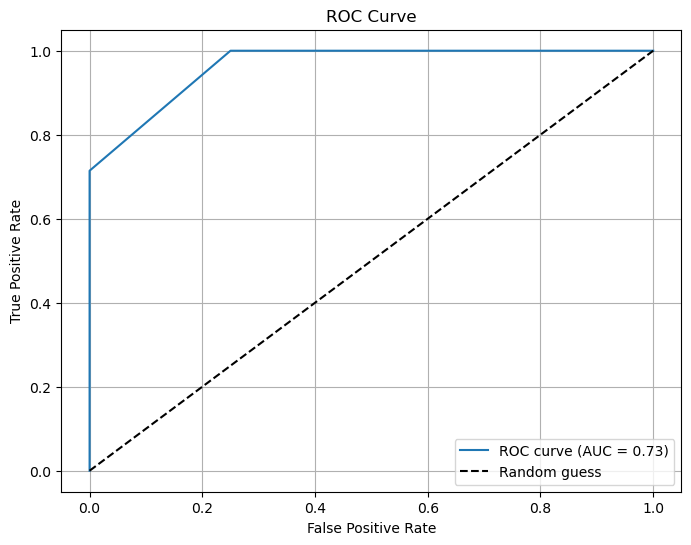

In [15]:
fpr, tpr = roccurve(test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roccurve.auc(test):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')  # Линия случайной модели
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

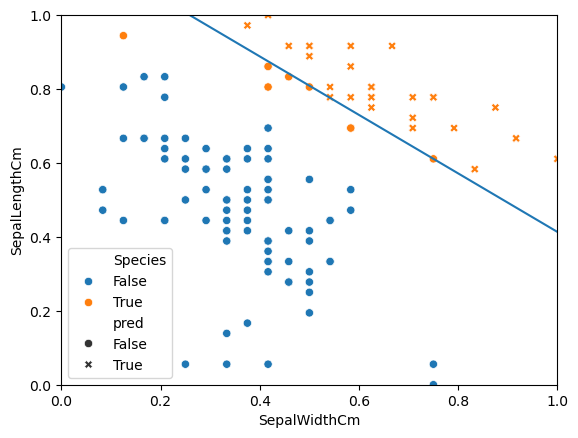

In [16]:
test["pred"] = model(test)
dataset["pred"] = model(dataset)
sns.scatterplot(
    dataset,
    x="SepalWidthCm",
    y="SepalLengthCm",
    hue=outcome,
    style="pred"
)
def line(x):
    w = model.parameter
    th = model.threshold
    return - (w[0] * x - np.log(th / (1 - th))) / w[1]
sns.lineplot(
    x=(0, 1),
    y=(line(0), line(1))
)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

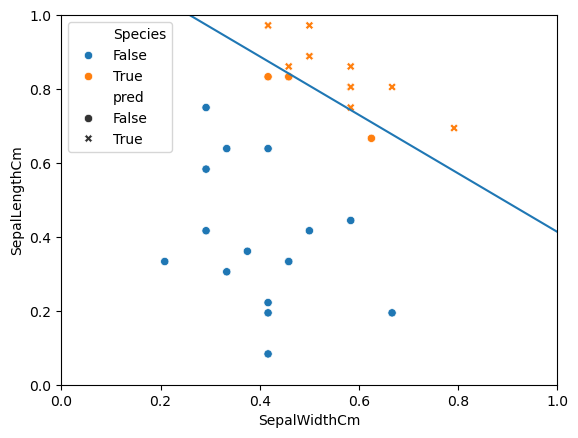

In [17]:
sns.scatterplot(
    test,
    x="SepalWidthCm",
    y="SepalLengthCm",
    hue=outcome,
    style="pred"
)
sns.lineplot(
    x=(0, 1),
    y=(line(0), line(1))
)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
